In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [89]:
%cd /content/drive/MyDrive/InvisMark

/content/drive/MyDrive/InvisMark


In [90]:
!pip install -r requirements.txt

In [91]:
!pip install datasets

In [92]:
import importlib
import metrics
import train
import noise
import utils
importlib.reload(utils)
import model
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

from datasets import load_dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [93]:
from PIL import Image
import torchvision.transforms.functional as TF
import os

# 1. 스트리밍 모드로 전체를 불러온다
ds_dalle = load_dataset("OpenDatasets/dalle-3-dataset", split='train', streaming=True)

# 2. transform 정의
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 사이즈 맞추기
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 3. 이미지 저장할 폴더 생성 (origin_img)
origin_img_dir = '/content/drive/MyDrive/origin_img'
os.makedirs(origin_img_dir, exist_ok=True)

# 4. 수동으로 50개 가져오고 저장
images = []
n = 50  # 사용할 이미지 수

for idx, example in enumerate(ds_dalle):
    img = example['image']
    if isinstance(img, Image.Image):
        # PIL 이미지 저장
        origin_save_path = os.path.join(origin_img_dir, f'original_{idx+1:02d}.png')
        img.save(origin_save_path)
        print(f"[{idx+1}/50] 원본 저장 완료 - {origin_save_path}")

        # 텐서로 변환해서 리스트에 저장
        img_tensor = transform(img)
        images.append(img_tensor)

    if len(images) >= n:
        break

# 5. 배치로 묶기
batch = torch.stack(images)  # (50, 3, 256, 256)

# 6. 데이터로더
dataloader = torch.utils.data.DataLoader(batch, batch_size=1, shuffle=False, num_workers=0)


Resolving data files:   0%|          | 0/67 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/67 [00:00<?, ?it/s]

[1/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_01.png
[2/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_02.png
[3/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_03.png
[4/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_04.png
[5/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_05.png
[6/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_06.png
[7/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_07.png
[8/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_08.png
[9/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_09.png
[10/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_10.png
[11/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_11.png
[12/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_12.png
[13/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_13.png
[14/50] 원본 저장 완료 - /content/drive/MyDrive/origin_img/original_14.png
[15/50] 원본 저장 완료 - /content/drive/MyDrive/o

In [94]:
ckpt_path = '/content/drive/MyDrive/InvisMarkd/paper.ckpt'
state_dict = torch.load(ckpt_path)
cfg = state_dict['config']
wm_model = train.Watermark(cfg)
wm_model.load_model(ckpt_path)

<ipython-input-94-111451d0bcf0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path)


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


/usr/local/lib/python3.11/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

## Apply transformation to the encoded images

In [95]:
from torchvision.transforms.functional import to_pil_image


save_dir = '/content/drive/MyDrive/watermarked_img'
psnr_list = []
ssim_list = []
bitacc_list = []

In [96]:
for idx, eval_batch in enumerate(dataloader):
    inputs = eval_batch
    secret, _ = utils.uuid_to_bits(inputs.shape[0])
    secret = secret[:, :100].to(device)

    with torch.no_grad():
      final_output, enc_input, enc_output = wm_model._encode(inputs, secret)

      psnr = metrics.image_psnr(inputs, final_output.cpu()).item()
      ssim = metrics.image_ssim(inputs, final_output.cpu()).item()
      extracted_secret = wm_model._decode(final_output)
      bitAcc = metrics.bit_accuracy(extracted_secret, secret).item()

    psnr_list.append(psnr)
    ssim_list.append(ssim)
    bitacc_list.append(bitAcc)

    # 이미지 저장
    img_tensor = final_output.squeeze(0).detach().cpu() * 0.5 + 0.5  # [0, 1] 범위로 복원
    img_pil = to_pil_image(img_tensor.clamp(0, 1))
    save_path = os.path.join(save_dir, f'wm_{idx+1:02d}.png')
    img_pil.save(save_path)

    print(f"[{idx+1}/50] 저장 완료 - {save_path}")
    print(f"[{idx+1}/{len(dataloader)}] 완료 - PSNR: {psnr:.2f}, SSIM: {ssim:.4f}, BitAcc: {bitAcc:.4f}")

[1/50] 저장 완료 - /content/drive/MyDrive/watermarked_img/wm_01.png
[1/50] 완료 - PSNR: 47.18, SSIM: 0.9976, BitAcc: 1.0000
[2/50] 저장 완료 - /content/drive/MyDrive/watermarked_img/wm_02.png
[2/50] 완료 - PSNR: 48.24, SSIM: 0.9980, BitAcc: 1.0000
[3/50] 저장 완료 - /content/drive/MyDrive/watermarked_img/wm_03.png
[3/50] 완료 - PSNR: 48.49, SSIM: 0.9978, BitAcc: 1.0000
[4/50] 저장 완료 - /content/drive/MyDrive/watermarked_img/wm_04.png
[4/50] 완료 - PSNR: 48.15, SSIM: 0.9985, BitAcc: 1.0000
[5/50] 저장 완료 - /content/drive/MyDrive/watermarked_img/wm_05.png
[5/50] 완료 - PSNR: 43.79, SSIM: 0.9980, BitAcc: 1.0000
[6/50] 저장 완료 - /content/drive/MyDrive/watermarked_img/wm_06.png
[6/50] 완료 - PSNR: 50.14, SSIM: 0.9979, BitAcc: 1.0000
[7/50] 저장 완료 - /content/drive/MyDrive/watermarked_img/wm_07.png
[7/50] 완료 - PSNR: 50.19, SSIM: 0.9974, BitAcc: 1.0000
[8/50] 저장 완료 - /content/drive/MyDrive/watermarked_img/wm_08.png
[8/50] 완료 - PSNR: 52.41, SSIM: 0.9985, BitAcc: 1.0000
[9/50] 저장 완료 - /content/drive/MyDrive/watermarked_img/wm

In [97]:
for i, b in enumerate(bitacc_list):
    if not isinstance(b, float):
        print(f"[{i}] 타입 이상: {type(b)}, 값: {b}")

bitacc_list = [float(b) if not isinstance(b, float) else b for b in bitacc_list]



In [98]:
print(psnr_list)
print(ssim_list)

[47.18400955200195, 48.24060821533203, 48.49119186401367, 48.1514778137207, 43.79014205932617, 50.14492416381836, 50.1949348449707, 52.40617752075195, 50.83348846435547, 42.28080749511719, 50.99016571044922, 49.83800506591797, 50.82545471191406, 50.893104553222656, 47.153564453125, 47.10126495361328, 48.71707534790039, 48.228477478027344, 48.21962356567383, 47.395729064941406, 49.857513427734375, 49.316524505615234, 47.96870040893555, 49.5444221496582, 47.837154388427734, 46.450172424316406, 47.29375457763672, 47.04364013671875, 46.45283508300781, 50.73332977294922, 51.73030090332031, 46.18248748779297, 48.17201614379883, 48.28712844848633, 47.25255584716797, 48.08351516723633, 42.76741027832031, 47.00621032714844, 48.467254638671875, 45.25996017456055, 45.935752868652344, 46.12651443481445, 45.69405746459961, 48.50094223022461, 51.205589294433594, 47.62993240356445, 48.97410583496094, 48.97909164428711, 44.78739929199219, 51.359954833984375]
[0.9975820183753967, 0.9979996681213379, 0.

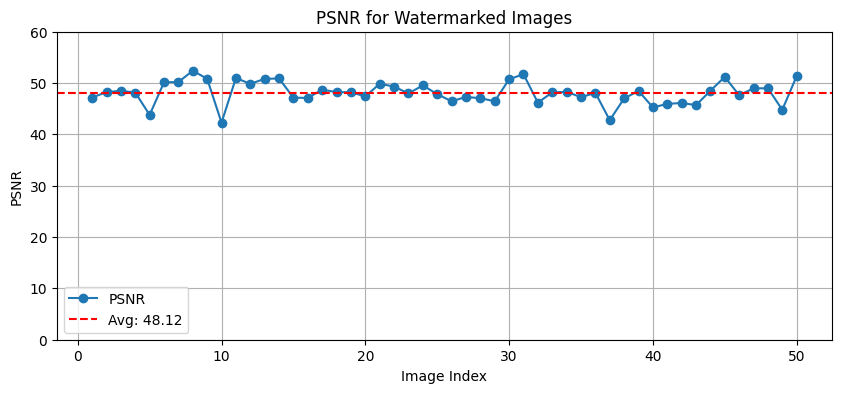

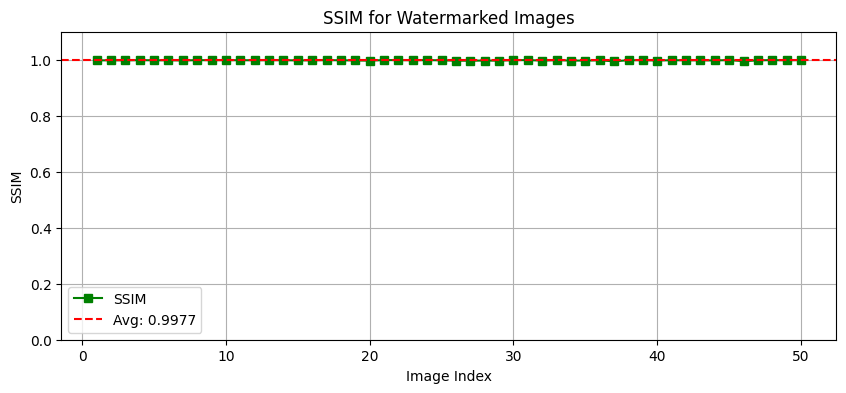

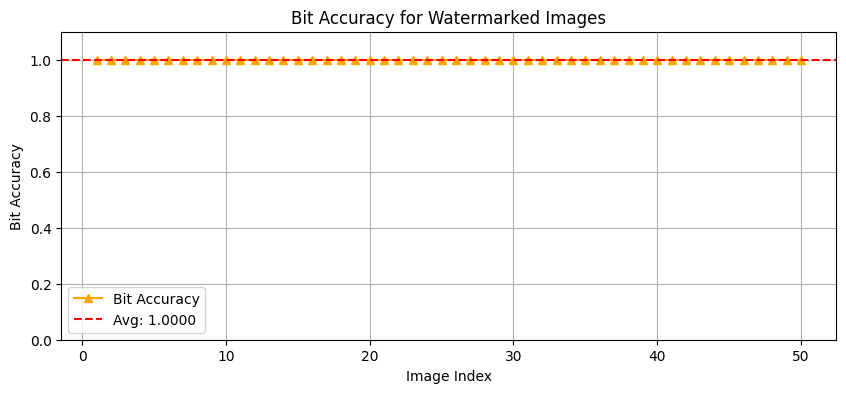

In [99]:
import matplotlib.pyplot as plt
import numpy as np

x = list(range(1, len(psnr_list) + 1))

# 평균 계산
avg_psnr = np.mean(psnr_list)
avg_ssim = np.mean(ssim_list)
avg_bitacc = np.mean(bitacc_list)

# PSNR 그래프
plt.figure(figsize=(10, 4))
plt.plot(x, psnr_list, marker='o', label='PSNR')
plt.axhline(y=avg_psnr, color='red', linestyle='--', label=f'Avg: {avg_psnr:.2f}')
plt.title('PSNR for Watermarked Images')
plt.xlabel('Image Index')
plt.ylabel('PSNR')
plt.ylim(0, 60)
plt.grid(True)
plt.legend()
plt.show()

# SSIM 그래프
plt.figure(figsize=(10, 4))
plt.plot(x, ssim_list, marker='s', color='green', label='SSIM')
plt.axhline(y=avg_ssim, color='red', linestyle='--', label=f'Avg: {avg_ssim:.4f}')
plt.title('SSIM for Watermarked Images')
plt.xlabel('Image Index')
plt.ylabel('SSIM')
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.show()

# Bit Accuracy 그래프
plt.figure(figsize=(10, 4))
plt.plot(x, bitacc_list, marker='^', color='orange', label='Bit Accuracy')
plt.axhline(y=avg_bitacc, color='red', linestyle='--', label=f'Avg: {avg_bitacc:.4f}')
plt.title('Bit Accuracy for Watermarked Images')
plt.xlabel('Image Index')
plt.ylabel('Bit Accuracy')
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.show()


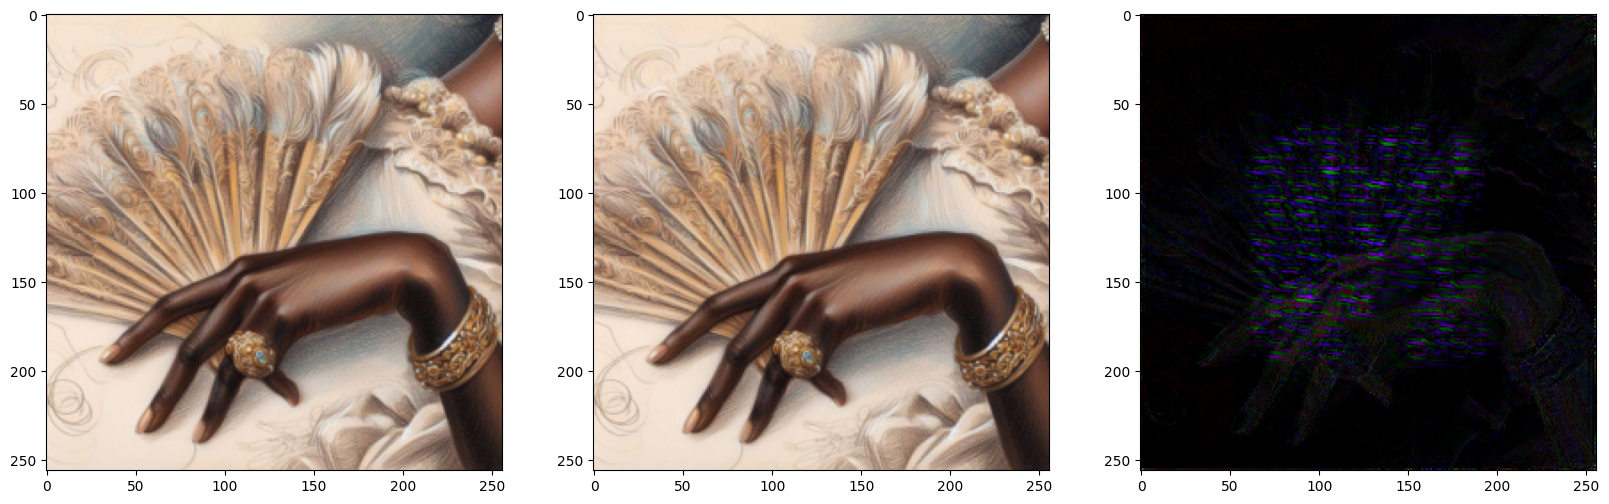

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(np.transpose(vutils.make_grid(inputs[0], padding=2, normalize=True, value_range=(-1,1)).cpu(),(1,2,0)))
ax[1].imshow(np.transpose(vutils.make_grid(final_output[0].detach(), padding=2, normalize=True, value_range=(-1,1)).cpu(),(1, 2, 0)))
ax[2].imshow(np.transpose(vutils.make_grid((final_output[0].cpu().detach()-inputs[0])*20., padding=2, value_range=(-1,1)).cpu(),(1, 2, 0)))

***
# WAVES 공격 이미지 워터마크 복원 후 이미지 품질 & Bit Acc 평가

In [104]:
from tqdm import tqdm

# 폴더 경로
origin_dir = '/content/drive/MyDrive/origin_img'
attacked_dir = '/content/drive/MyDrive/attacked_img'

# 결과 저장 리스트
attacked_psnr_list = []
attacked_ssim_list = []
attacked_bitacc_list = []

# 이미지 50장 루프
for idx in tqdm(range(50)):
    # 1. 원본 이미지 불러오기
    orig_path = os.path.join(origin_dir, f'original_{idx+1:02d}.png')
    orig_pil = Image.open(orig_path).convert("RGB")
    orig_tensor = TF.to_tensor(orig_pil)
    orig_tensor = TF.resize(orig_tensor, [256, 256])
    orig_tensor = (orig_tensor - 0.5) / 0.5  # Normalize to [-1, 1]
    orig_tensor = orig_tensor.unsqueeze(0).to(device)

    # 2. 공격 이미지 불러오기
    att_path = os.path.join(attacked_dir, f'attacked_{idx+1:02d}.png')
    att_pil = Image.open(att_path).convert("RGB")
    att_tensor = TF.to_tensor(att_pil).unsqueeze(0)
    att_tensor = (att_tensor - 0.5) / 0.5
    att_tensor = att_tensor.to(device)

    # 3. 시크릿 생성 (원래와 동일하게 uuid 기반)
    secret, _ = utils.uuid_to_bits(att_tensor.shape[0])
    secret = secret[:, :100].to(device)

    # 4. 워터마크 복원 및 이미지 품질 측정
    with torch.no_grad():
        extracted_secret = wm_model._decode(att_tensor)
        psnr = metrics.image_psnr(orig_tensor.cpu(), att_tensor.cpu()).item()
        ssim = metrics.image_ssim(orig_tensor.cpu(), att_tensor.cpu()).item()
        bitAcc = metrics.bit_accuracy(extracted_secret, secret).item()

    # 5. 결과 저장
    attacked_psnr_list.append(psnr)
    attacked_ssim_list.append(ssim)
    attacked_bitacc_list.append(bitAcc)

    print(f"[{idx+1}/50] 완료 - PSNR: {psnr:.2f}, SSIM: {ssim:.4f}, BitAcc: {bitAcc:.4f}")

  4%|▍         | 2/50 [00:00<00:06,  7.82it/s]

[1/50] 완료 - PSNR: 26.03, SSIM: 0.7298, BitAcc: 0.5400
[2/50] 완료 - PSNR: 26.01, SSIM: 0.7512, BitAcc: 0.4600


  8%|▊         | 4/50 [00:00<00:05,  7.94it/s]

[3/50] 완료 - PSNR: 26.08, SSIM: 0.7303, BitAcc: 0.5800
[4/50] 완료 - PSNR: 26.03, SSIM: 0.7869, BitAcc: 0.5800


 12%|█▏        | 6/50 [00:00<00:05,  7.72it/s]

[5/50] 완료 - PSNR: 26.27, SSIM: 0.7914, BitAcc: 0.5700
[6/50] 완료 - PSNR: 26.13, SSIM: 0.5076, BitAcc: 0.5800


 16%|█▌        | 8/50 [00:00<00:04,  8.44it/s]

[7/50] 완료 - PSNR: 3.40, SSIM: -0.1308, BitAcc: 0.5500
[8/50] 완료 - PSNR: 25.99, SSIM: 0.4956, BitAcc: 0.5000


 18%|█▊        | 9/50 [00:01<00:04,  8.61it/s]

[9/50] 완료 - PSNR: 25.99, SSIM: 0.5822, BitAcc: 0.5000


 22%|██▏       | 11/50 [00:01<00:05,  6.66it/s]

[10/50] 완료 - PSNR: 26.46, SSIM: 0.7877, BitAcc: 0.5200
[11/50] 완료 - PSNR: 26.06, SSIM: 0.5063, BitAcc: 0.4700


 26%|██▌       | 13/50 [00:01<00:04,  7.74it/s]

[12/50] 완료 - PSNR: 26.14, SSIM: 0.5506, BitAcc: 0.4800
[13/50] 완료 - PSNR: 26.05, SSIM: 0.4424, BitAcc: 0.4700


 30%|███       | 15/50 [00:01<00:04,  7.79it/s]

[14/50] 완료 - PSNR: 9.47, SSIM: 0.0323, BitAcc: 0.5700
[15/50] 완료 - PSNR: 26.20, SSIM: 0.7002, BitAcc: 0.5700


 34%|███▍      | 17/50 [00:02<00:04,  8.01it/s]

[16/50] 완료 - PSNR: 26.32, SSIM: 0.7202, BitAcc: 0.5300
[17/50] 완료 - PSNR: 26.22, SSIM: 0.6903, BitAcc: 0.4800


 38%|███▊      | 19/50 [00:02<00:03,  8.28it/s]

[18/50] 완료 - PSNR: 26.24, SSIM: 0.7241, BitAcc: 0.3900
[19/50] 완료 - PSNR: 26.20, SSIM: 0.6129, BitAcc: 0.5700


 42%|████▏     | 21/50 [00:02<00:03,  8.41it/s]

[20/50] 완료 - PSNR: 26.28, SSIM: 0.6317, BitAcc: 0.5600
[21/50] 완료 - PSNR: 26.06, SSIM: 0.6551, BitAcc: 0.4600


 46%|████▌     | 23/50 [00:02<00:03,  8.49it/s]

[22/50] 완료 - PSNR: 26.08, SSIM: 0.6510, BitAcc: 0.5700
[23/50] 완료 - PSNR: 26.40, SSIM: 0.6520, BitAcc: 0.5500


 48%|████▊     | 24/50 [00:03<00:03,  8.48it/s]

[24/50] 완료 - PSNR: 26.03, SSIM: 0.7377, BitAcc: 0.4400


 50%|█████     | 25/50 [00:03<00:06,  3.76it/s]

[25/50] 완료 - PSNR: 26.03, SSIM: 0.7731, BitAcc: 0.5000


 52%|█████▏    | 26/50 [00:04<00:07,  3.05it/s]

[26/50] 완료 - PSNR: 26.21, SSIM: 0.7137, BitAcc: 0.5700


 54%|█████▍    | 27/50 [00:04<00:08,  2.70it/s]

[27/50] 완료 - PSNR: 26.48, SSIM: 0.6150, BitAcc: 0.5700


 56%|█████▌    | 28/50 [00:05<00:08,  2.53it/s]

[28/50] 완료 - PSNR: 26.11, SSIM: 0.6847, BitAcc: 0.5100


 58%|█████▊    | 29/50 [00:05<00:08,  2.35it/s]

[29/50] 완료 - PSNR: 26.76, SSIM: 0.5888, BitAcc: 0.5000


 60%|██████    | 30/50 [00:06<00:09,  2.18it/s]

[30/50] 완료 - PSNR: 26.03, SSIM: 0.5721, BitAcc: 0.5400


 62%|██████▏   | 31/50 [00:06<00:08,  2.14it/s]

[31/50] 완료 - PSNR: 26.09, SSIM: 0.5324, BitAcc: 0.5600


 64%|██████▍   | 32/50 [00:07<00:09,  1.97it/s]

[32/50] 완료 - PSNR: 26.45, SSIM: 0.6501, BitAcc: 0.5800


 66%|██████▌   | 33/50 [00:07<00:08,  1.89it/s]

[33/50] 완료 - PSNR: 26.16, SSIM: 0.7217, BitAcc: 0.5200


 68%|██████▊   | 34/50 [00:08<00:08,  1.97it/s]

[34/50] 완료 - PSNR: 26.05, SSIM: 0.6865, BitAcc: 0.5200


 70%|███████   | 35/50 [00:08<00:07,  2.02it/s]

[35/50] 완료 - PSNR: 26.44, SSIM: 0.6513, BitAcc: 0.5200


 72%|███████▏  | 36/50 [00:09<00:07,  1.99it/s]

[36/50] 완료 - PSNR: 26.54, SSIM: 0.6236, BitAcc: 0.5200


 74%|███████▍  | 37/50 [00:09<00:06,  1.91it/s]

[37/50] 완료 - PSNR: 27.10, SSIM: 0.6663, BitAcc: 0.5100


 76%|███████▌  | 38/50 [00:10<00:05,  2.01it/s]

[38/50] 완료 - PSNR: 26.23, SSIM: 0.7396, BitAcc: 0.6200


 78%|███████▊  | 39/50 [00:10<00:05,  2.03it/s]

[39/50] 완료 - PSNR: 26.18, SSIM: 0.6751, BitAcc: 0.5900


 80%|████████  | 40/50 [00:11<00:04,  2.09it/s]

[40/50] 완료 - PSNR: 26.78, SSIM: 0.6334, BitAcc: 0.5100


 84%|████████▍ | 42/50 [00:11<00:02,  2.77it/s]

[41/50] 완료 - PSNR: 26.61, SSIM: 0.6348, BitAcc: 0.5500
[42/50] 완료 - PSNR: 26.66, SSIM: 0.6422, BitAcc: 0.4100


 88%|████████▊ | 44/50 [00:11<00:01,  4.28it/s]

[43/50] 완료 - PSNR: 26.83, SSIM: 0.6724, BitAcc: 0.5400
[44/50] 완료 - PSNR: 26.11, SSIM: 0.6729, BitAcc: 0.5400


 92%|█████████▏| 46/50 [00:12<00:00,  5.72it/s]

[45/50] 완료 - PSNR: 26.09, SSIM: 0.6061, BitAcc: 0.4800
[46/50] 완료 - PSNR: 26.11, SSIM: 0.4886, BitAcc: 0.5900


 96%|█████████▌| 48/50 [00:12<00:00,  6.43it/s]

[47/50] 완료 - PSNR: 26.13, SSIM: 0.5168, BitAcc: 0.5400
[48/50] 완료 - PSNR: 26.04, SSIM: 0.7859, BitAcc: 0.4300


100%|██████████| 50/50 [00:12<00:00,  3.95it/s]

[49/50] 완료 - PSNR: 26.58, SSIM: 0.7889, BitAcc: 0.4800
[50/50] 완료 - PSNR: 26.03, SSIM: 0.6630, BitAcc: 0.5800


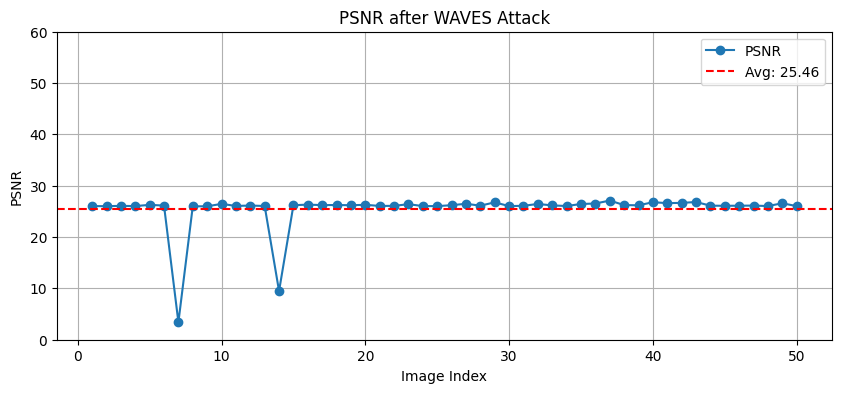

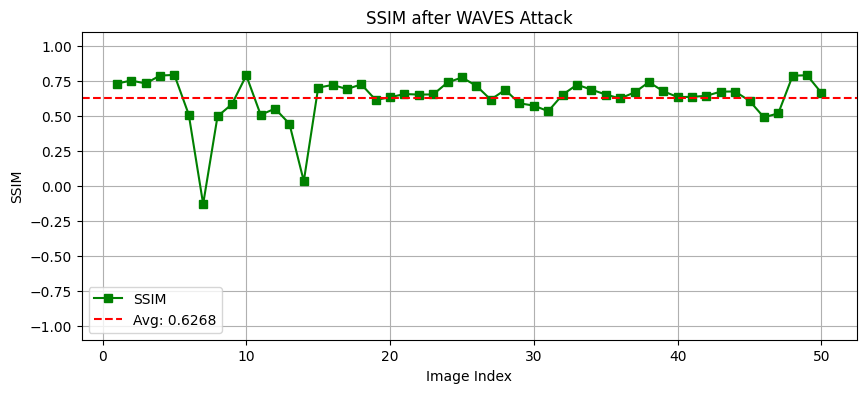

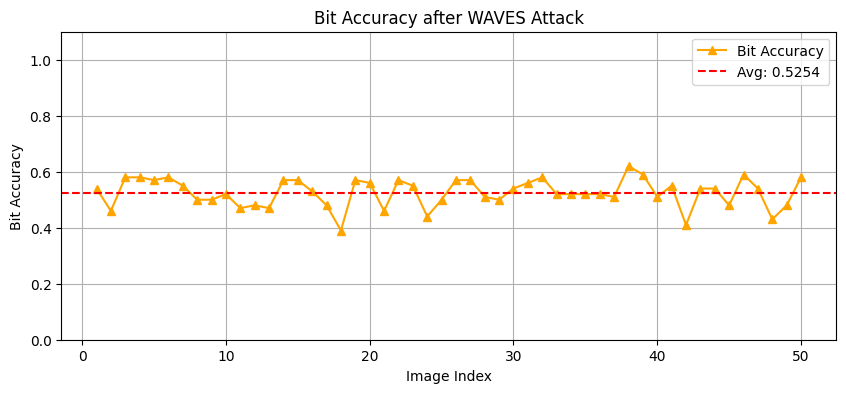

In [105]:
x = list(range(1, 51))

plt.figure(figsize=(10, 4))
plt.plot(x, attacked_psnr_list, marker='o', label='PSNR')
plt.axhline(np.mean(attacked_psnr_list), color='red', linestyle='--', label=f'Avg: {np.mean(attacked_psnr_list):.2f}')
plt.ylim(0, 60)
plt.title("PSNR after WAVES Attack")
plt.xlabel("Image Index")
plt.ylabel("PSNR")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x, attacked_ssim_list, marker='s', color='green', label='SSIM')
plt.axhline(np.mean(attacked_ssim_list), color='red', linestyle='--', label=f'Avg: {np.mean(attacked_ssim_list):.4f}')
plt.ylim(-1.1, 1.1)
plt.title("SSIM after WAVES Attack")
plt.xlabel("Image Index")
plt.ylabel("SSIM")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x, attacked_bitacc_list, marker='^', color='orange', label='Bit Accuracy')
plt.axhline(np.mean(attacked_bitacc_list), color='red', linestyle='--', label=f'Avg: {np.mean(attacked_bitacc_list):.4f}')
plt.ylim(0, 1.1)
plt.title("Bit Accuracy after WAVES Attack")
plt.xlabel("Image Index")
plt.ylabel("Bit Accuracy")
plt.legend()
plt.grid(True)
plt.show()


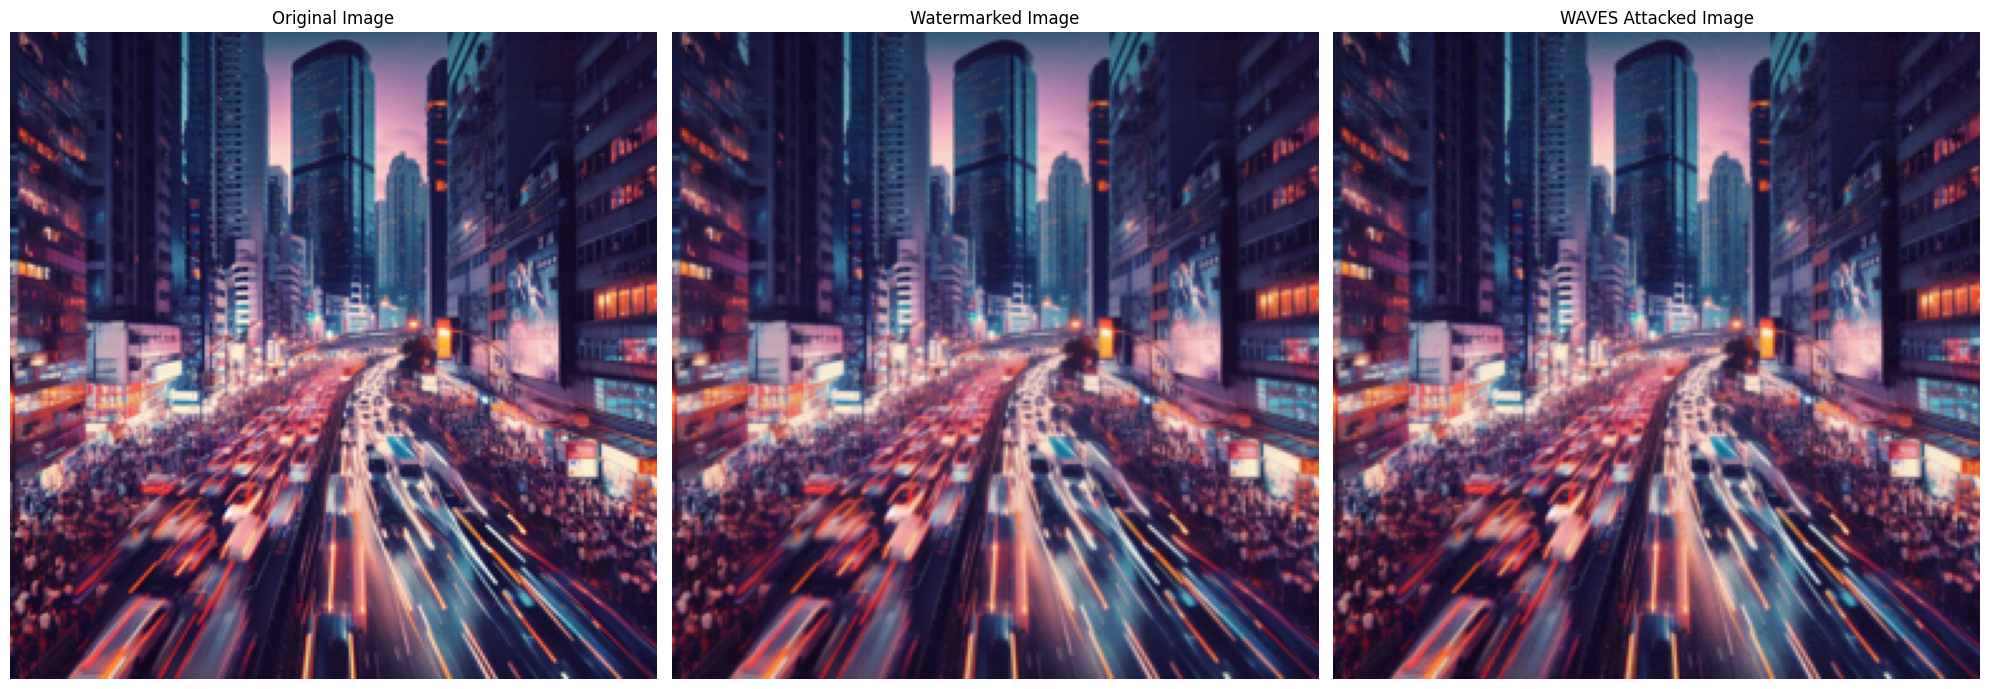

In [106]:
# 이미지 경로 설정
origin_dir = '/content/drive/MyDrive/origin_img'
watermarked_dir = '/content/drive/MyDrive/watermarked_img'
attacked_dir = '/content/drive/MyDrive/attacked_img'

idx = 0  # 예시 이미지 인덱스

# 이미지 로드 및 정규화 함수
def load_tensor(path):
    img = Image.open(path).convert("RGB").resize((256, 256))
    tensor = TF.to_tensor(img)
    return (tensor - 0.5) / 0.5

# 이미지 불러오기
origin_tensor = load_tensor(os.path.join(origin_dir, f'original_{idx+1:02d}.png'))
wm_tensor = load_tensor(os.path.join(watermarked_dir, f'wm_{idx+1:02d}.png'))
att_tensor = load_tensor(os.path.join(attacked_dir, f'attacked_{idx+1:02d}.png'))

# 시각화
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(np.transpose(vutils.make_grid(origin_tensor, normalize=True, value_range=(-1,1)), (1,2,0)))
ax[0].set_title("Original Image")
ax[1].imshow(np.transpose(vutils.make_grid(wm_tensor, normalize=True, value_range=(-1,1)), (1,2,0)))
ax[1].set_title("Watermarked Image")
ax[2].imshow(np.transpose(vutils.make_grid(att_tensor, normalize=True, value_range=(-1,1)), (1,2,0)))
ax[2].set_title("WAVES Attacked Image")
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

***
# WAVES의 각 공격 유형마다 10단계 강도로 나누어 이미지 품질 & Bit Acc 시각화


▶ 공격 유형: .ipynb_checkpoints


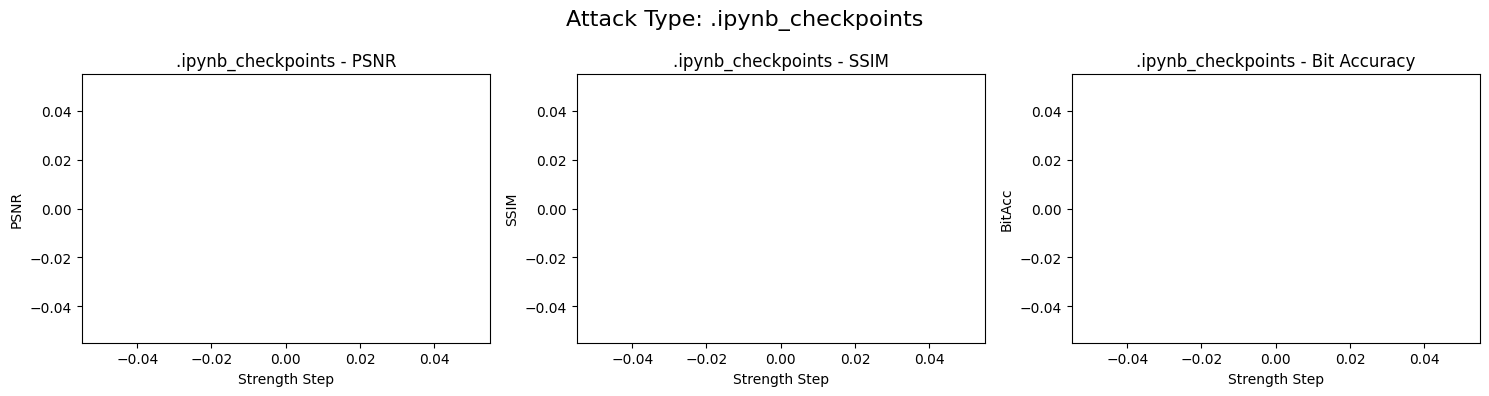


▶ 공격 유형: blurring


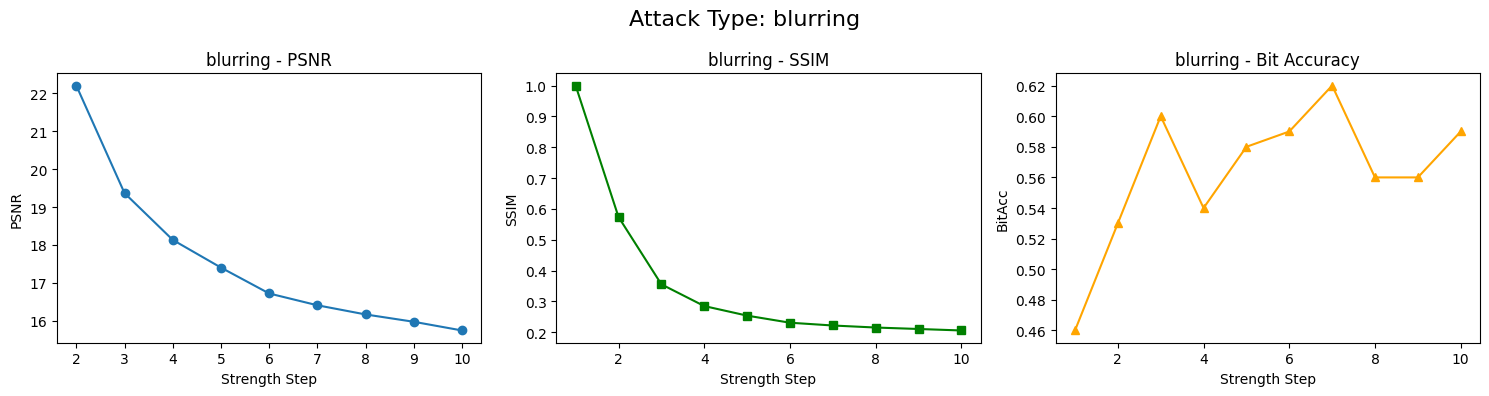


▶ 공격 유형: brightness


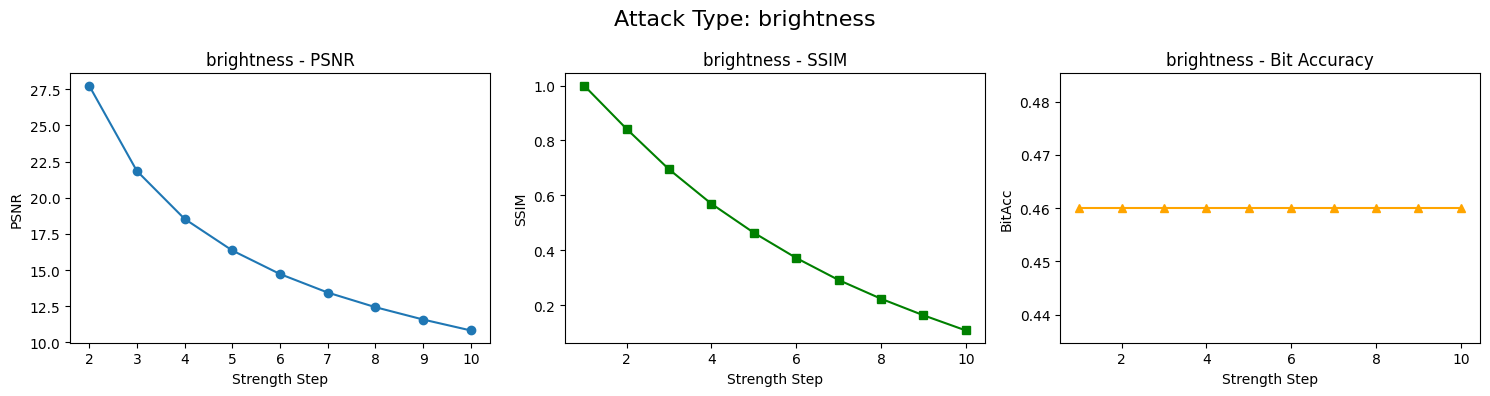


▶ 공격 유형: compression


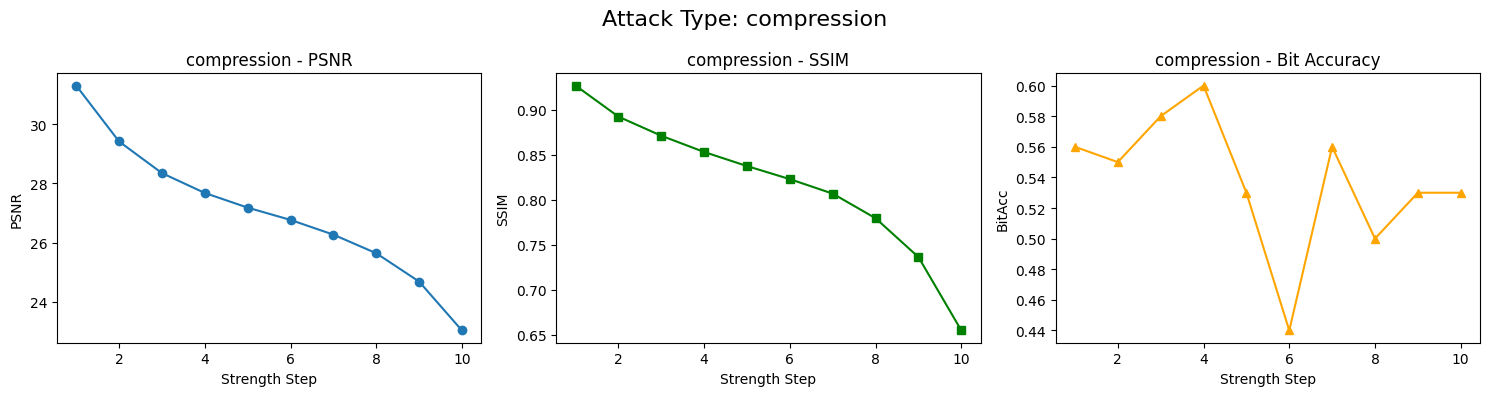


▶ 공격 유형: contrast


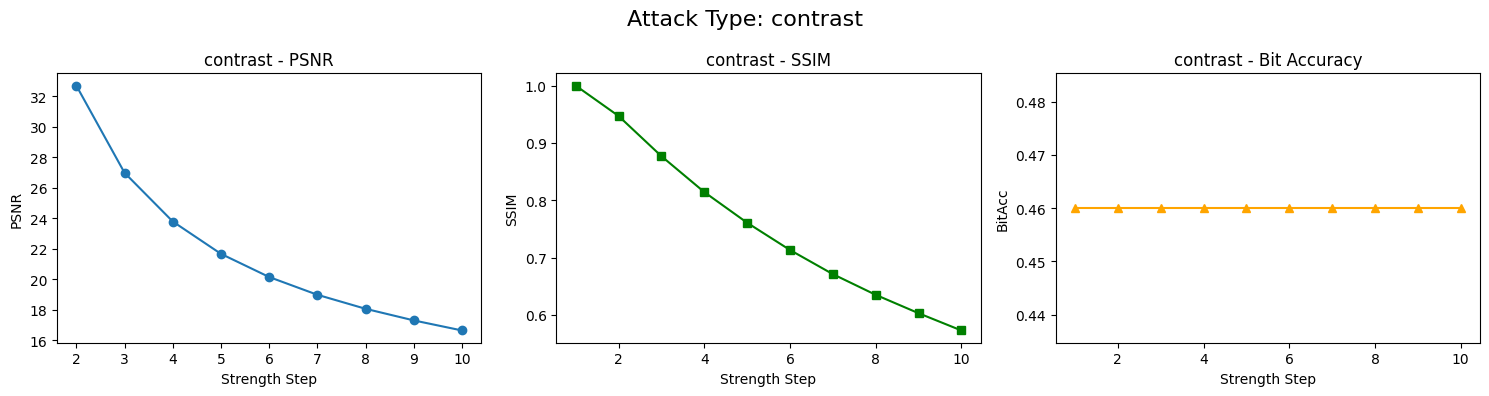


▶ 공격 유형: erasing


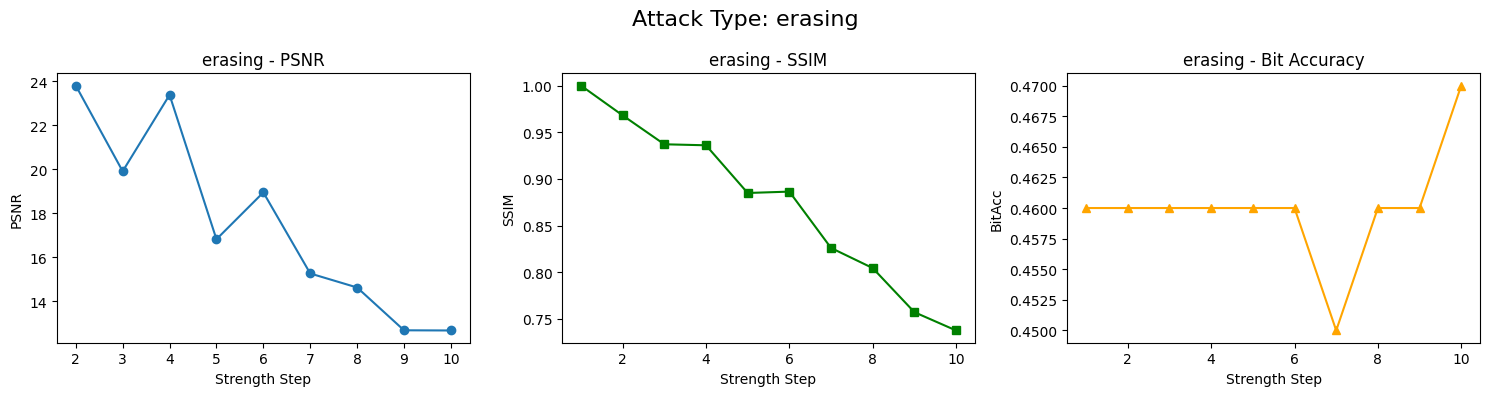


▶ 공격 유형: noise


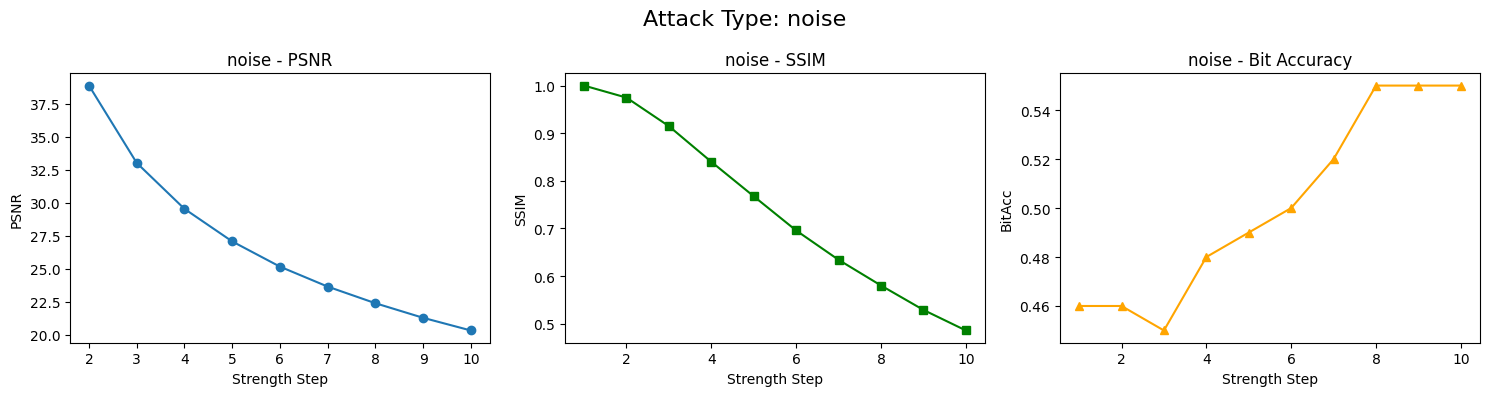


▶ 공격 유형: resizedcrop


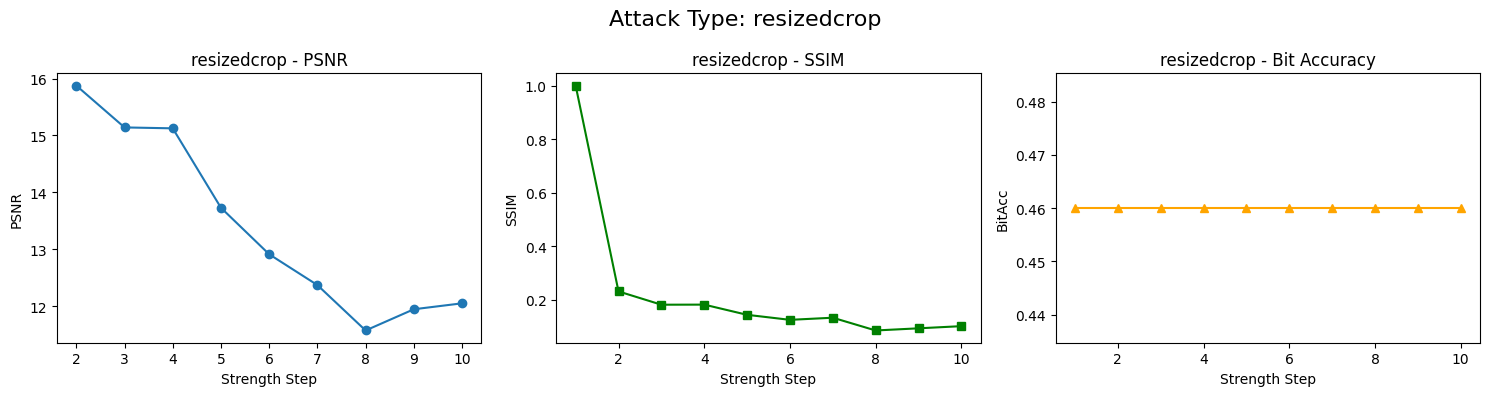


▶ 공격 유형: rotation


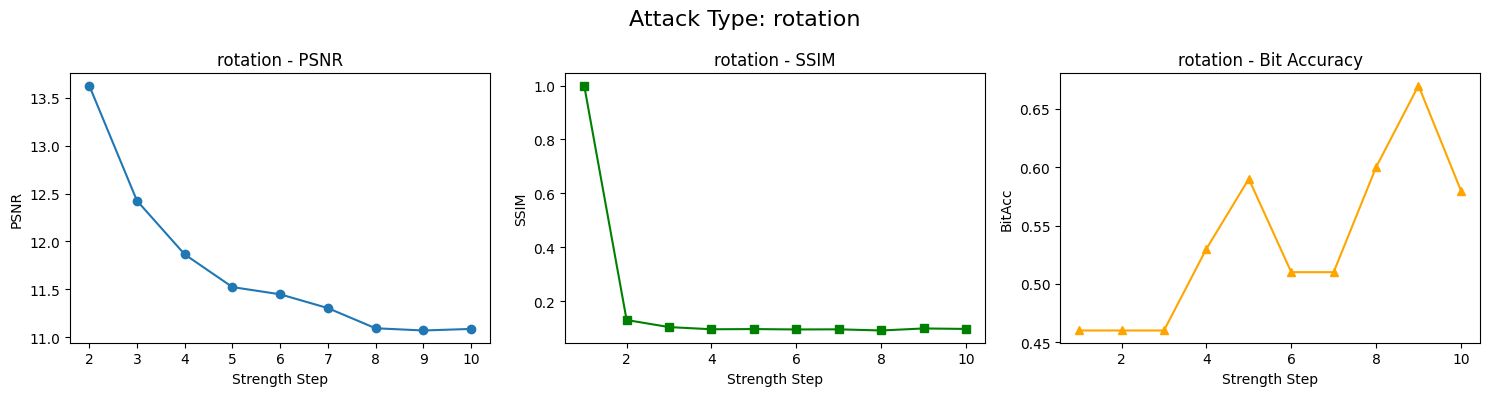

In [107]:
# 경로 설정
origin_img_path = "/content/drive/MyDrive/watermarked_img/wm_01.png"
attack_base_dir = "/content/drive/MyDrive/attack"

# 디바이스 설정
device = torch.device("cpu")
wm_model.to(device)

# 원본 이미지 불러오기
orig_pil = Image.open(origin_img_path).convert("RGB")
orig_tensor = TF.to_tensor(orig_pil)
orig_tensor = TF.resize(orig_tensor, [256, 256])
orig_tensor = (orig_tensor - 0.5) / 0.5
orig_tensor = orig_tensor.unsqueeze(0).to(device)

# 시크릿 생성
secret, _ = utils.uuid_to_bits(1)
secret = secret[:, :100].to(device)

# 공격 폴더별 반복
for attack_type in sorted(os.listdir(attack_base_dir)):
    folder_path = os.path.join(attack_base_dir, attack_type)
    if not os.path.isdir(folder_path):
        continue

    print(f"\n▶ 공격 유형: {attack_type}")

    psnr_list = []
    ssim_list = []
    bitacc_list = []

    for i in range(1, 11):
        img_path = os.path.join(folder_path, f"{attack_type}_{i:02d}.png")
        if not os.path.exists(img_path):
            continue

        att_pil = Image.open(img_path).convert("RGB")
        att_tensor = TF.to_tensor(att_pil).unsqueeze(0)
        att_tensor = (att_tensor - 0.5) / 0.5
        att_tensor = att_tensor.to(device)

        with torch.no_grad():
            extracted_secret = wm_model._decode(att_tensor)
            psnr = metrics.image_psnr(orig_tensor, att_tensor).item()
            ssim = metrics.image_ssim(orig_tensor, att_tensor).item()
            bitacc = metrics.bit_accuracy(extracted_secret, secret).item()

        psnr_list.append(psnr)
        ssim_list.append(ssim)
        bitacc_list.append(bitacc)

    # 그래프 시각화
    x = list(range(1, len(psnr_list) + 1))
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(x, psnr_list, marker='o')
    plt.title(f"{attack_type} - PSNR")
    plt.xlabel("Strength Step")
    plt.ylabel("PSNR")

    plt.subplot(1, 3, 2)
    plt.plot(x, ssim_list, marker='s', color='green')
    plt.title(f"{attack_type} - SSIM")
    plt.xlabel("Strength Step")
    plt.ylabel("SSIM")

    plt.subplot(1, 3, 3)
    plt.plot(x, bitacc_list, marker='^', color='orange')
    plt.title(f"{attack_type} - Bit Accuracy")
    plt.xlabel("Strength Step")
    plt.ylabel("BitAcc")

    plt.suptitle(f"Attack Type: {attack_type}", fontsize=16)
    plt.tight_layout()
    plt.show()
